## README

I followed the attached link to learn how pytorch neural nets work and and how to create a playing card classifier.

https://www.youtube.com/watch?v=tHL5STNJKag

In [1]:
!pip3 install torch torchvision timm matplotlib pandas numpy tqdm ipywidgets

In [2]:
import torch
import torch.nn as nn # provides neural network functions like convolution layers
import torch.optim as optim # provides optimizer
from torch.utils.data import Dataset, DataLoader
import torchvision # helps working with images easier
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
import timm # pytorch image model library, pretrained weights optimized for image classification

import matplotlib.pyplot as plt # data visualization
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm # for progress bar
import os
from PIL import Image
import random

## STEP 1: Set up data set and date loader

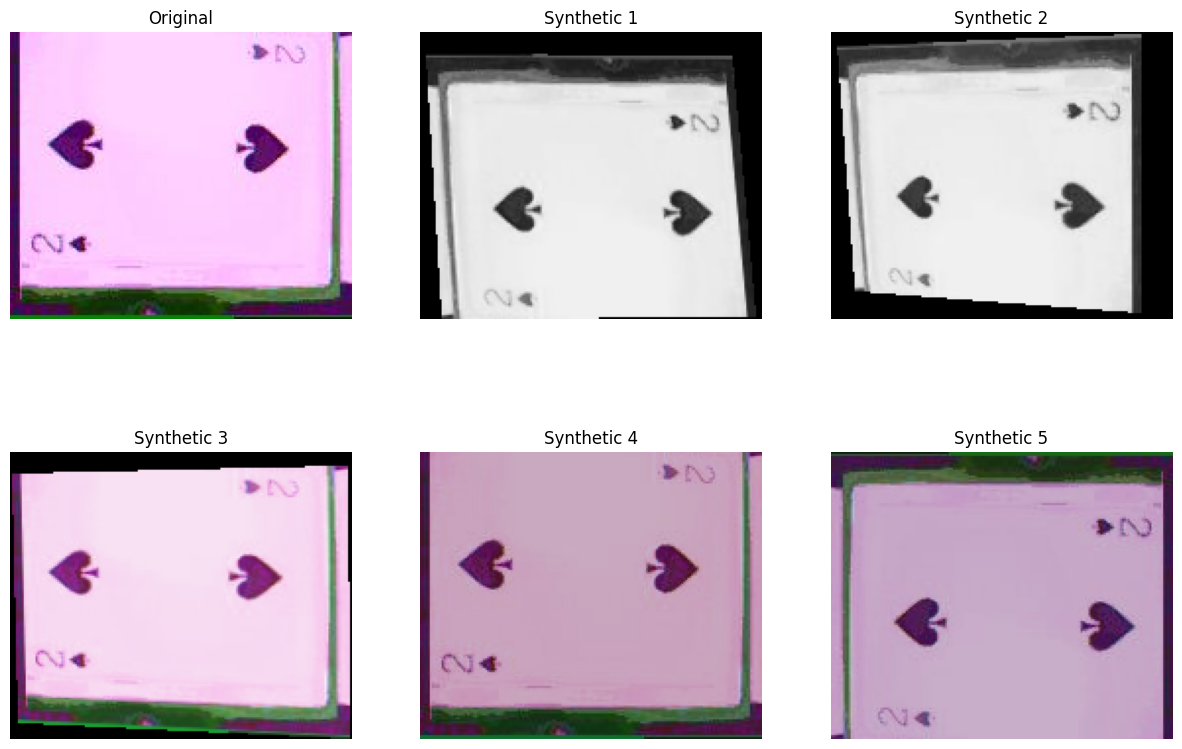

In [3]:
# Generate synthethic images
def random_rotate_180(img):
    return img.rotate(180) if random.random() < 0.5 else img

transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.Lambda(random_rotate_180),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

card = "two of spades"
folder_name = os.path.join(os.getcwd(), "data", "cam", card)
cam_data_path = os.path.join(folder_name, "2spade.jpg")
image = Image.open(cam_data_path)

# display + save
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(image)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Apply transformations to create synthetic images and plot them
for i in range(1, 6):
    synthetic_image = transform(image)
    axes[i // 3, i % 3].imshow(synthetic_image.permute(1, 2, 0))
    axes[i // 3, i % 3].set_title(f'Synthetic {i}')
    axes[i // 3, i % 3].axis('off')

    synthetic_image_pil = transforms.ToPILImage()(synthetic_image)
    synthetic_image_pil.save(os.path.join(folder_name, f"image{i}.jpg"))

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()
    

In [4]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) # Creates classes using folder name
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
    

# # map target to class by creating classes per folder, and map them using indexes
# target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()} # note: v: k is for flipping class to idx to be idx to class

# transform input images
transform = transforms.Compose([
    transforms.Resize((128, 128)), # resize input image to desired pixel dimensions
    transforms.RandomRotation(90),   # Rotate each image by 90 degrees for OV7670 roateted image
    transforms.ToTensor(), # converts pixel RGB val from [0,255] -> [0,1]
])

train_dir = os.path.join(os.getcwd(), "data", "train")
valid_dir = os.path.join(os.getcwd(), "data", "valid")
test_dir = os.path.join(os.getcwd(), "data", "test")


train_dataset = PlayingCardDataset(train_dir, transform)
valid_dataset = PlayingCardDataset(valid_dir, transform)
test_dataset = PlayingCardDataset(test_dir, transform)

# Data loading
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
## STEP 2: Design Neural Network

In [6]:
class CardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifer, self).__init__()

        # note: could design image classification architecture ourself by defining each layer
        # however, using an optimized image classificatino model with pretrained weights using timm
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)  

        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280 # default size of the efficientnet_b0, we will resize enout into our num of classe later

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


## STEP 2: Train + Validate

In [7]:
# Note: want to validate the model on data it hasn't been trained on => split data into train and valid dataset.
# Terms: Epoch = one run through entire training dataset, step = one batch of data

# general idea: Load data in model in batches, then calculate loss and perform backpropagation to modify weights starting from last layer to minimize that loss

# training parameters
 
num_epochs = 1
train_losses, val_losses = [], []

model = CardClassifer()

criterion = nn.CrossEntropyLoss() # loss function (what model optimizes to minimize loss)
optimizer = optim.Adam(model.parameters(), lr=0.001)




In [8]:
train = False
if train:
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc='Training loop'):
            optimizer.zero_grad()
            outputs = model(images) # call forward on the images
            loss = criterion(outputs, labels)
            loss.backward() # backpropagation to update model weight
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation loop'):
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
else: # load in already trained model
    # model = timm.create_model('efficientnet_b0', pretrained=False)  # define architetcture of model
    model_weights_path = "model.pth"
    model.load_state_dict(torch.load(model_weights_path))
    model.eval() # set to eval mode

## Assessing the model

In [9]:
from PIL import Image

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    # image = image.rotate(90)
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        probabilities = probabilities.cpu().numpy().flatten()
        print(train_dataset.classes[np.argmax(probabilities)])
    return probabilities

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

two of spades


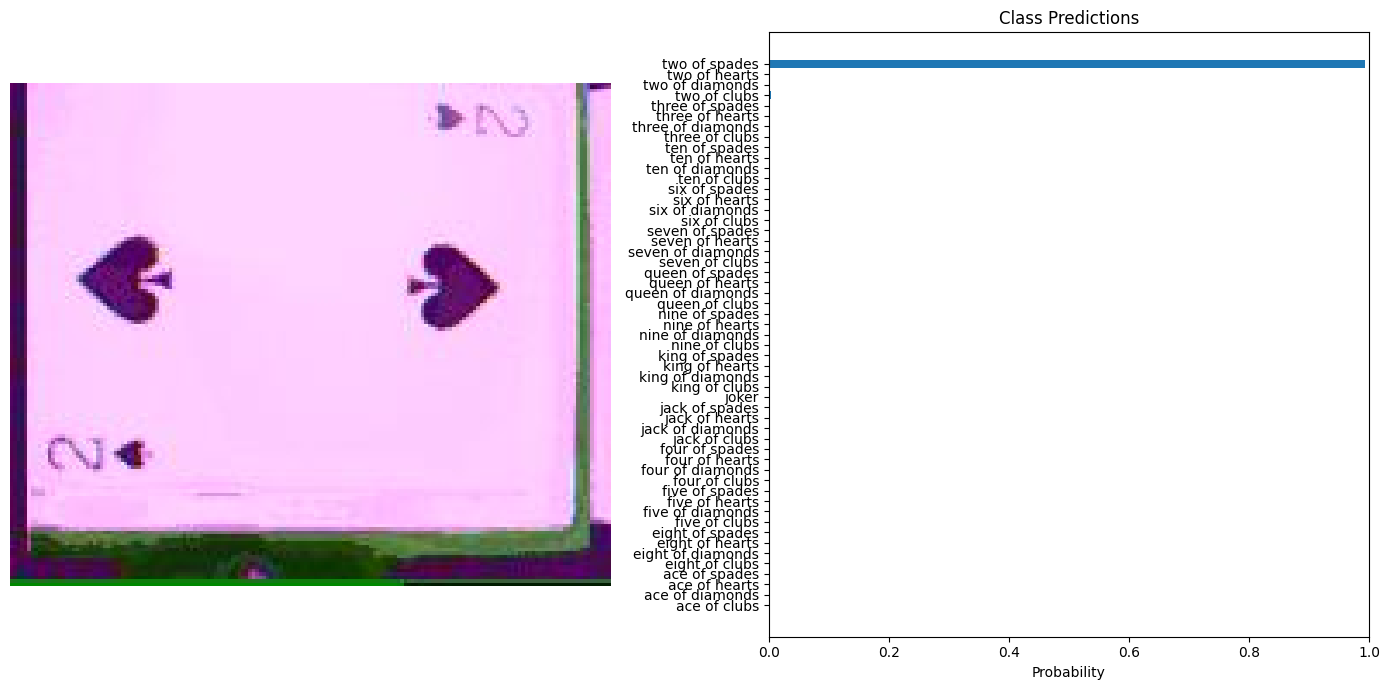

two of spades


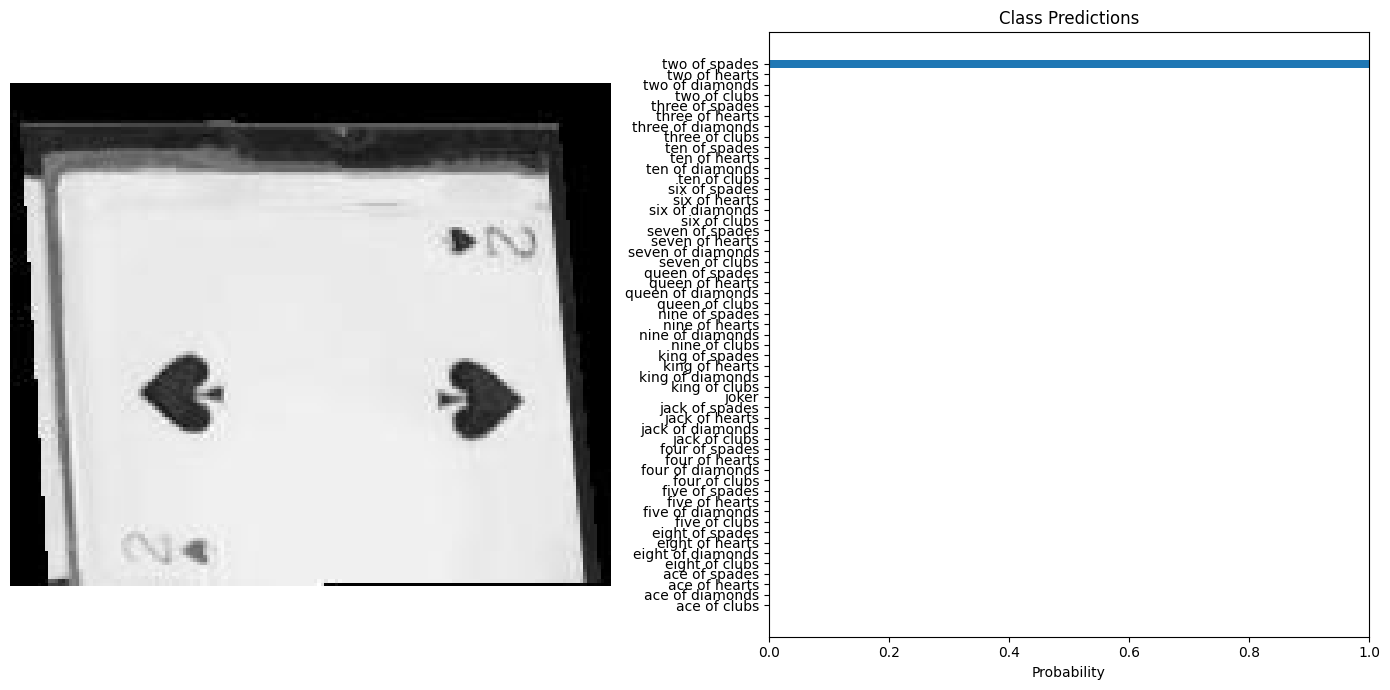

two of spades


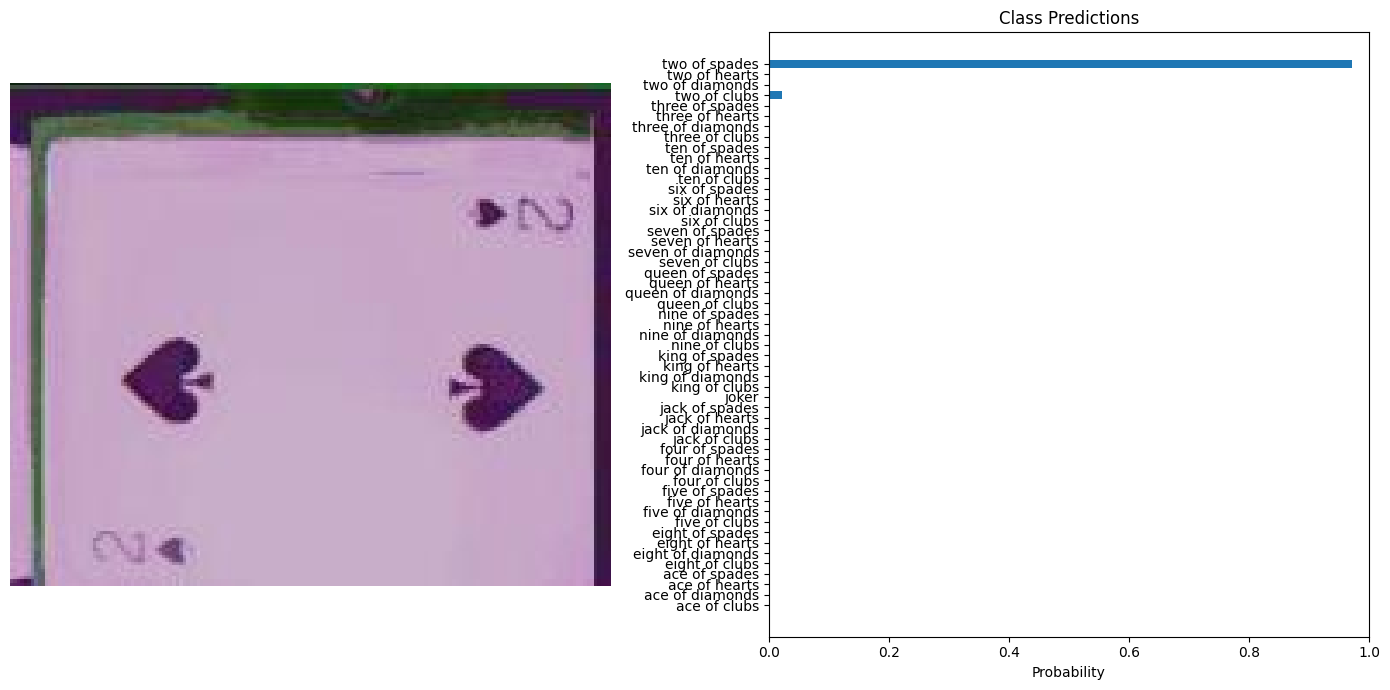

two of spades


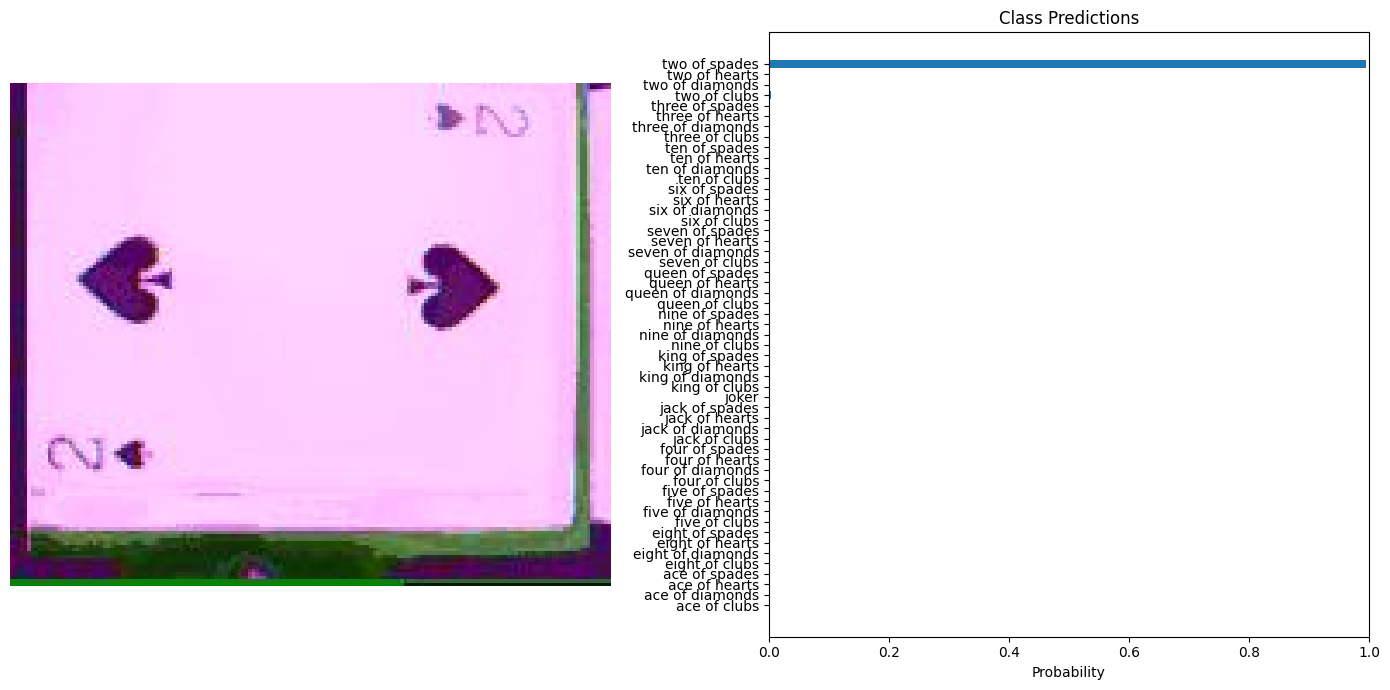

two of spades


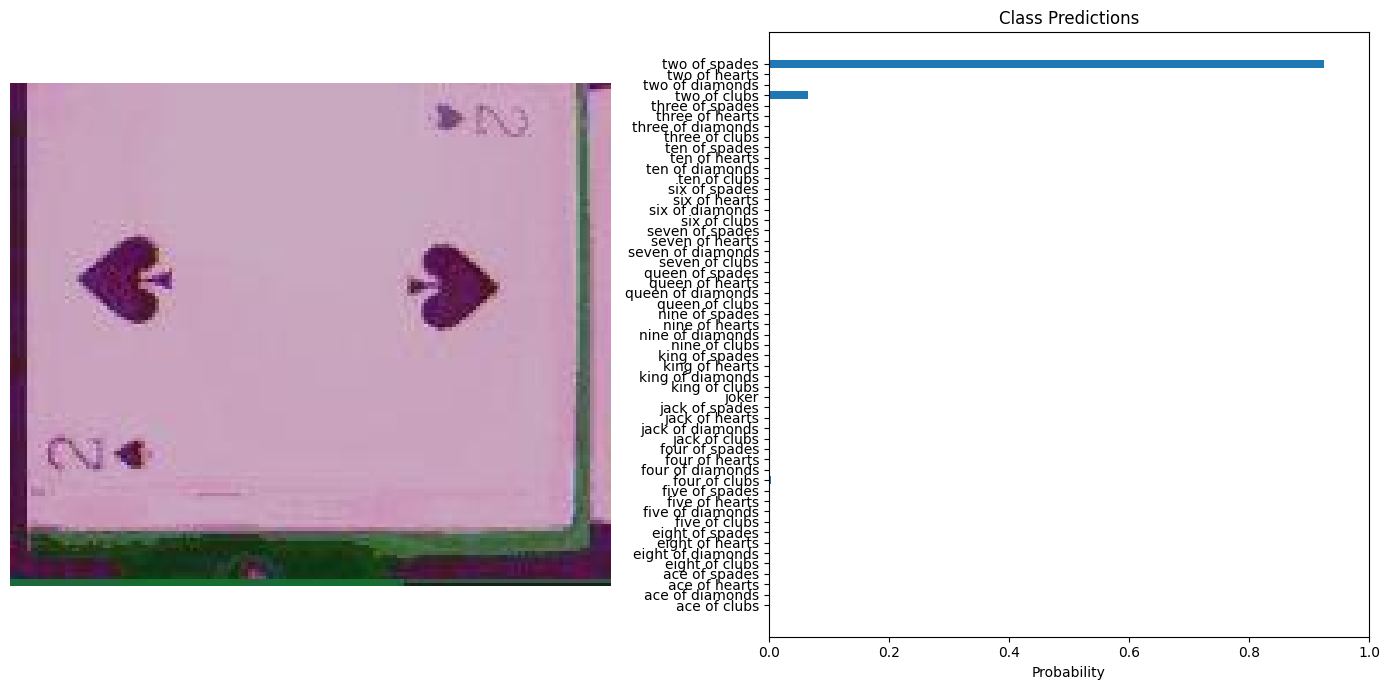

In [10]:
from glob import glob
test_images = glob('data/cam/*/*')
test_examples = np.random.choice(test_images, 5)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor)

    # Assuming dataset.classes gives the class names
    class_names = train_dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

## Step 3: Save the state_dict of the model as a pth

In [11]:
# save .pth (trained weighted sums)
model_path = "model.pth"
torch.save(model.state_dict(), model_path)